In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from astroML.utils import split_samples
from sklearn.utils import shuffle


import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from keras import models
from keras import layers

In [13]:
def R2_metric(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

---

# The data

In this section we will do the following:
* Read the data file
* Define which parameter we will study
* Visualize the data
* Normalize and split the data

In [2]:
# Reading the file

file = 'splus_starlight.dat'
data = pd.read_csv(file, sep='\s', engine='python')

data.describe()

,RA,Dec,uJAVA_petro,F378_petro,F395_petro,F410_petro,F430_petro,g_petro,F515_petro,r_petro,...,S2NHa,umg,gmr,rmi,imz,mlr,Mstar,log_b,SSFRb,SSFRc
count,55803.000000,55803.00000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,...,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000,55803.000000
mean,138.231885,0.00393,20.027314,19.776800,19.621324,19.431730,19.178868,18.650515,18.357072,17.899382,...,36.989763,1.322796,0.560430,0.262130,0.177857,1.570874,10.599283,-169.754161,-178.171912,-138.150262
std,146.670946,0.73467,1.353688,1.323287,1.366704,1.363994,1.361901,1.249274,1.262739,1.195358,...,40.751580,0.968667,0.315053,0.218044,0.370836,1.096660,0.876807,374.735594,370.931642,331.203317
min,0.000700,-1.28200,9.860000,9.530000,9.430000,8.120000,8.140000,7.010000,7.020000,6.390000,...,0.000000,-14.087000,-3.779000,-22.495000,-18.823000,0.006000,3.822000,-999.000000,-999.000000,-999.000000
25%,22.874600,-0.64500,19.320000,19.100000,18.910000,18.740000,18.490000,18.000000,17.700000,17.260000,...,4.288500,0.905000,0.409000,0.211000,0.106000,0.722000,10.062000,-1.719000,-11.856000,-11.840000
50%,46.664300,0.01810,20.040000,19.800000,19.640000,19.470000,19.240000,18.720000,18.420000,17.990000,...,24.571000,1.179000,0.557000,0.271000,0.227000,1.279000,10.693000,-0.491000,-10.628000,-10.739000
75%,323.955450,0.63765,20.760000,20.500000,20.370000,20.190000,19.970000,19.450000,19.170000,18.760000,...,54.361000,1.548000,0.713000,0.336000,0.302000,2.229000,11.210000,0.102000,-10.035000,-10.143000
max,359.997800,1.27330,31.020000,28.690000,29.160000,28.800000,29.130000,25.070000,25.060000,21.040000,...,398.506000,23.285000,23.643000,6.326000,23.042000,6.406000,16.372000,2.747000,-7.390000,-8.009000


Let's take a look at the distribution of our 13 features (12 S-PLUS filters + redshift)

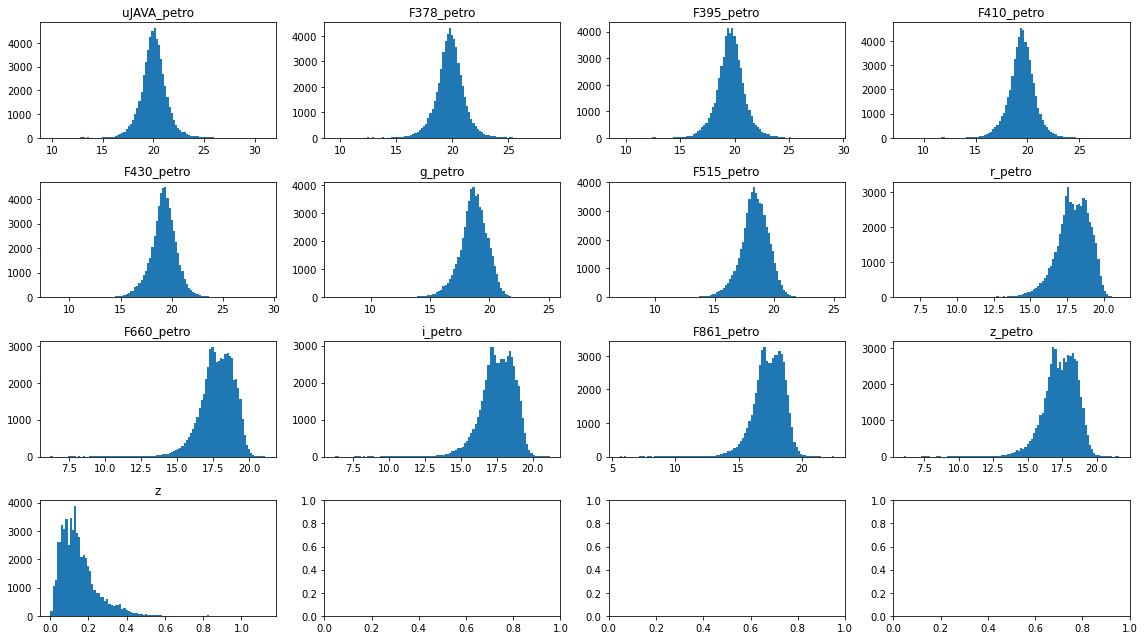

In [3]:
features = ['uJAVA_petro', 'F378_petro', 'F395_petro', 'F410_petro',
            'F430_petro', 'g_petro', 'F515_petro', 'r_petro', 'F660_petro',
            'i_petro', 'F861_petro', 'z_petro', 'z']  # 12 filter + 1 z

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(16,9))

for i in range(3):
    for j in range(4):
        axs[i][j].hist(data[features[(i)*4 + j]], bins=100)
        axs[i][j].set_title(features[(i)*4 + j])

# Plotting the redshift distribution
axs[3][0].hist(data[features[-1]], bins=100)
axs[3][0].set_title(features[-1])
        
plt.tight_layout()
plt.show()


## Defining the expecting parameter

We will only be studying the mean star age pondered by flux (**t_flux**) parameter. Other parameters should present similar results.


In [4]:
# The parameter that we will be studying
param = 't_flux'

if param in data.columns:
    print(f"All good to go! {param} is a valid parameter")
else:
    print("Something is wrong. You need to choose a valid parameter from data.columns!")

All good to go! t_flux is a valid parameter


Let's take a look at the target parameter data to see its distribution.

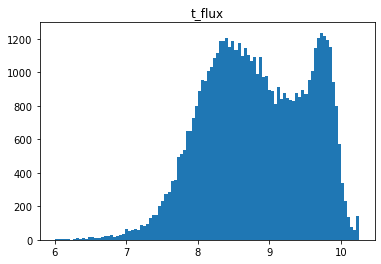

In [5]:
plt.hist(data[param], bins=100)
plt.title(param)
plt.show()

## Normalizing and splitting the data

Note that at the end of the project we want to run through the model some S-PLUS data that is NOT normalized. This means that for us to have a more robust perception of how the model will perform we need to remove the validation and test data from the initial normalization of the training and validation sets. There is an argument to be made towards not separating the validation data from the training data when normalizing, but we think that this discussion needs more time to develope.

In [6]:
# Seprating the data into two sets: train and test (80% and 20% split)
(data_train, data_test) , (target_train, target_test) = split_samples(data[features], data[param], 
                                                                      [0.8, 0.2],
                                                                      random_state = 1234) # for reproducibility

# Targets need to be reshaped for Keras to read
target_train = np.reshape(target_train, (-1, 1))
target_test  = np.reshape(target_test, (-1, 1))

In [7]:
# Scaling the data

# Generating the scalers
scaler_data = MinMaxScaler()
scaler_targets = MinMaxScaler()

# Fitting the scalers into the train data 
scaler_data.fit(data_train)
scaler_targets.fit(target_train)

# Scaling train and validation sets
data_train = scaler_data.transform(data_train)
data_test  = scaler_data.transform(data_test)

target_train = scaler_targets.transform(target_train)
target_test  = scaler_targets.transform(target_test)

---

# The Model

We can easily categorize our problem as a Regression problem. Remember that the final goal of this project is to create a network that can take a given S-PLUS photometric data and return a single galaxy parameter. There are many ways that we can approach a regression problem: with Neural Networks, with Classical Machine Learning models (e.g. Random Forest), *etc*. Here we are going to apply a simple Neural Network. 

Here are the steps we will follow in this section:
* Create builder to the Neural Network
* Run a K-Fold Cross-Validation for a high number of epochs
* Analyze the history of the network

## Building the Network



In [61]:
def build_network(data_train):
    '''Builds the network model'''

    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(data_train.shape[1],)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))
    
    opt = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse', R2_metric])
    
    return model

## Using K-Fold Cross-Validation

Note: this might take several minutes to complete. In my computer, it took ~2 hours.

In [ ]:
mae_history = []
fold_number = 0

import time
start = time.time()

for train, val in KFold(n_splits = 8).split(data_train, target_train):
    
    # Cleaning cluttering data from Keras 
    K.clear_session()
    
    # Building the model
    model = build_network(data_train)
    
    # Print for user feedback
    print(f'------ Training fold number {fold_number} ------')
    
    # Training the model
    history = model.fit(data_train[train], target_train[train],
                        validation_data=(data_train[val], target_train[val]),
                        epochs=500, batch_size=128, verbose=0)
    
    # Obtaining relevant validation data
    mae_history.append(history.history['val_mae'])
    
    fold_number += 1
    
end = time.time()
print(f"This run took {end - start} seconds")

------ Training fold number 0 ------
------ Training fold number 1 ------
------ Training fold number 2 ------
------ Training fold number 3 ------
------ Training fold number 4 ------


In [ ]:
# Calculating the average MAE history
average_mae_history = [np.mean([x[i] for x in mae_history]) for i in range(500)]

# Finding the best value for the epoch
best_epoch = average_mae_history.index(min(average_mae_history))

# Plotting the validation MAE for 
plt.figure(figsize=(16,9))
plt.plot(range(10, len(average_mae_history) + 1), average_mae_history[9:])
plt.axvline(best_epoch, c='r', ls='--')
plt.title(f"Best epoch: {best_epoch}", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Average Validation MAE", fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['val_loss'][9:], label='val')
plt.plot(history.history['loss'][9:], label='train')
plt.legend()

In [53]:
# Cleaning cluttering data from Keras 
K.clear_session()

# Building the model
model = build_network(data_train)

# Print for user feedback
print(f'------ Training fold number {fold_number} ------')

# Training the model
history = model.fit(data_train, target_train,
                    epochs=best_epoch, batch_size=128, verbose=0)

# Obtaining relevant validation data
# mae_history.append(history.history['val_mae'])

results = model.evaluate(data_test, target_test, batch_size=128)


fold_number += 1

------ Training fold number 8 ------
88/88 [==============================] - 0s 559us/step - loss: 0.0108 - mae: 0.0795 - mse: 0.0108 - R2_metric: 0.6257


In [60]:
print(f"Test Loss: {results[0]}")
print(f"Test  MAE: {results[1]}")
print(f"Test  MSE: {results[2]}")
print(f"Test   R2: {results[3]}")

Test Loss: 0.010827580466866493
Test  MAE: 0.07952322065830231
Test  MSE: 0.010827580466866493
Test   R2: 0.6257242560386658


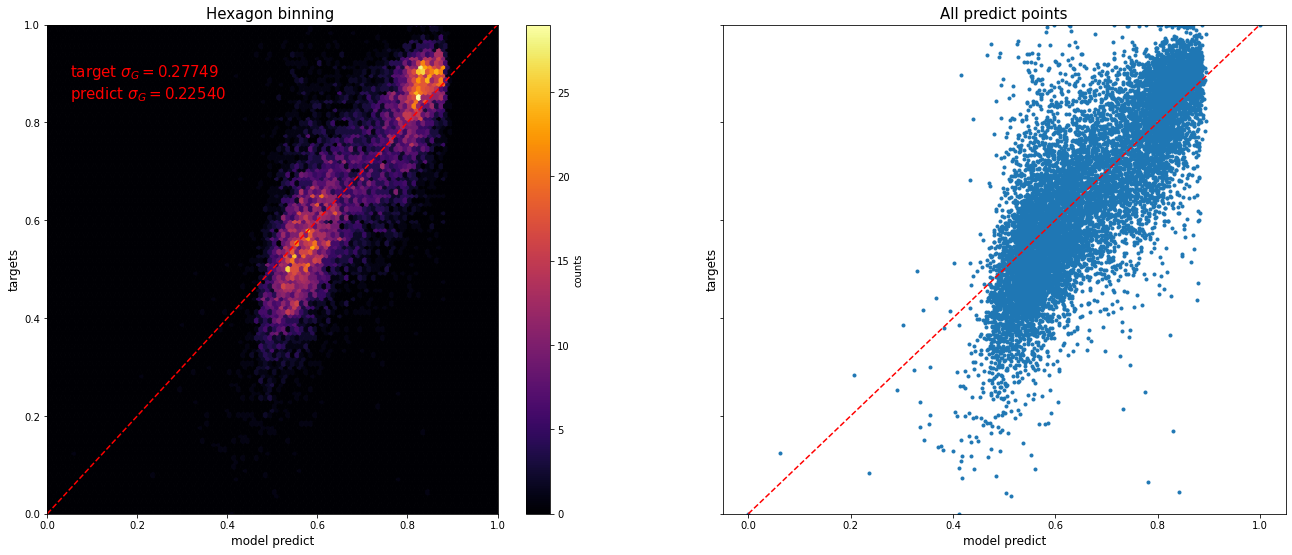

In [54]:
# Calculate interquartile range
q3, q1 = np.percentile(model.predict(data_test), [75, 25])
predict_iqr = q3 - q1
q3, q1 = np.percentile(target_test, [75, 25])
targets_iqr = q3 - q1

# creating the plots
x = np.append(np.array(model.predict(data_test)), np.array([0, 1]))
y = np.append(np.array(target_test), np.array([0, 1]))
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(20, 9))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb = ax.hexbin(x, y, gridsize=100, cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title(f"Hexagon binning ", fontsize=15)
ax.set_xlabel("model predict", fontsize=12)
ax.set_ylabel("targets", fontsize=12)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.plot([0, 1], [0, 1], '--r')
ax.text(0.05, 0.85, r'target $\sigma_{G} = $' + '{:.5f}'.format(
    targets_iqr) + '\n' + r'predict $\sigma_{G} = $' + '{:.5f}'.format(predict_iqr),
        fontsize=15, color='r')

ax = axs[1]
ax.plot(x, y, '.')
ax.plot([0, 1], [0, 1], 'r--')
ax.set_title(f"All predict points", fontsize=15)
ax.set_xlabel("model predict", fontsize=12)
ax.set_ylabel("targets", fontsize=12)

# plt.savefig(f"{self._file}/predicts.png")
plt.show()

In [46]:
history